In [13]:
import numpy as np
import pandas as pd
import json, string
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [14]:
pathTrain = '../fdata/train/'
pathVal = '../fdata/val/'
annotation_dir_train = pathTrain + "annotations.json"
objData_train = json.load(open(annotation_dir_train))

annotation_dir_val = pathVal + "annotations.json"
objData_val = json.load(open(annotation_dir_val))

In [15]:
objData_val.keys()

dict_keys(['categories', 'info', 'images', 'annotations'])

In [16]:
objData_val['categories'][:2]

[{'id': 50,
  'name': 'beetroot-steamed-without-addition-of-salt',
  'name_readable': 'Beetroot, steamed, without addition of salt',
  'supercategory': 'food'},
 {'id': 101246,
  'name': 'bread_wholemeal',
  'name_readable': 'bread_wholemeal',
  'supercategory': 'food'}]

In [17]:
objData_val['images'][0:2]

[{'id': 149022, 'file_name': '149022.jpg', 'width': 455, 'height': 455},
 {'id': 85697, 'file_name': '085697.jpg', 'width': 852, 'height': 852}]

In [18]:
objData_val['annotations'][:2]

[{'id': 233459,
  'image_id': 149022,
  'category_id': 101182,
  'segmentation': [[214.0,
    152.5,
    175.0,
    144.5,
    156.5,
    133.0,
    153.5,
    119.0,
    159.5,
    99.0,
    168.0,
    89.5,
    191.0,
    77.5,
    231.99999999999997,
    73.5,
    258.0,
    80.5,
    279.5,
    95.0,
    285.5,
    104.0,
    288.5,
    122.0,
    278.0,
    137.5,
    250.00000000000003,
    148.5]],
  'area': 8225.0,
  'bbox': [77.5, 153.5, 136.5, 135.0],
  'iscrowd': 0},
 {'id': 237814,
  'image_id': 149022,
  'category_id': 100563,
  'segmentation': [[327.315625,
    304.90686111450196,
    83.890625,
    271.919361114502,
    65.690625,
    361.78186111450196,
    319.35312500000003,
    409.556861114502,
    320.49062499999997,
    312.86936111450194]],
  'area': 24367.0,
  'bbox': [65.690625, 65.690625, 261.625, 261.625],
  'iscrowd': 0}]

In [19]:
type(objData_val['annotations'])
len(objData_val['annotations'])

1708

In [20]:
len(objData_val['images'])

946

In [21]:
coordinate_matrix = []
for i in objData_val['annotations']:
    if i['image_id'] == 149022:
        coordinate_matrix.append(i['segmentation'][0])
print(len(coordinate_matrix[1]))

10


In [22]:
print(len(coordinate_matrix[0]))

28


In [23]:
len(coordinate_matrix)

2

In [24]:
new_list = []
for i in range(0, len(coordinate_matrix)):
    for j in coordinate_matrix[i]:
        new_list.append(j)

In [25]:
len(new_list)

38

In [26]:
coordinate_matrix = np.array(new_list)
coordinate_matrix

array([214.        , 152.5       , 175.        , 144.5       ,
       156.5       , 133.        , 153.5       , 119.        ,
       159.5       ,  99.        , 168.        ,  89.5       ,
       191.        ,  77.5       , 232.        ,  73.5       ,
       258.        ,  80.5       , 279.5       ,  95.        ,
       285.5       , 104.        , 288.5       , 122.        ,
       278.        , 137.5       , 250.        , 148.5       ,
       327.315625  , 304.90686111,  83.890625  , 271.91936111,
        65.690625  , 361.78186111, 319.353125  , 409.55686111,
       320.490625  , 312.86936111])

In [27]:
x_coordinate = coordinate_matrix[::2]
x_coordinate

array([214.      , 175.      , 156.5     , 153.5     , 159.5     ,
       168.      , 191.      , 232.      , 258.      , 279.5     ,
       285.5     , 288.5     , 278.      , 250.      , 327.315625,
        83.890625,  65.690625, 319.353125, 320.490625])

In [28]:
y_coordinate = coordinate_matrix[1::2]
y_coordinate 

array([152.5       , 144.5       , 133.        , 119.        ,
        99.        ,  89.5       ,  77.5       ,  73.5       ,
        80.5       ,  95.        , 104.        , 122.        ,
       137.5       , 148.5       , 304.90686111, 271.91936111,
       361.78186111, 409.55686111, 312.86936111])

In [29]:
top_left = np.array([x_coordinate.min(), y_coordinate.min()])
bottom_right = np.array([x_coordinate.max(), y_coordinate.max()])

In [30]:
top_left

array([65.690625, 73.5     ])

In [31]:
bottom_right

array([327.315625  , 409.55686111])

In [32]:
def crop_seg(coordinate_matrix, width, height):
    new_list = []
    for i in range(0, len(coordinate_matrix)):
        for j in coordinate_matrix[i]:
            new_list.append(j)

    coordinate_matrix = np.array(new_list)
    x_coordinate = coordinate_matrix[::2]
    y_coordinate = coordinate_matrix[1::2]
    top_left = np.array([x_coordinate.min(), y_coordinate.min()])
    bottom_right = np.array([x_coordinate.max(), y_coordinate.max()])
    temp = bottom_right*1.1
    bottom_right[0] = min(temp[0], width)
    bottom_right[1] = min(temp[1], height)

    return top_left*0.8, bottom_right

In [33]:
coordinate_matrix = []
for i in objData_val['annotations']:
    if i['image_id'] == 149022:
        coordinate_matrix.append(i['bbox'])
coordinate_matrix

[[77.5, 153.5, 136.5, 135.0], [65.690625, 65.690625, 261.625, 261.625]]

In [34]:
def handle_crop(coordinate_matrix):
    coordinate_matrix = np.array(coordinate_matrix)
    coordinate_matrix[:,2] += coordinate_matrix[:,1]
    coordinate_matrix[:,3] += coordinate_matrix[:,0]
    A1 = coordinate_matrix[:,:2].min(axis = 0)
    A2 = coordinate_matrix[:,2:].max(axis = 0)
    return A2 - A1

In [35]:
def handle_crop_image(coordinate_matrix, width, height):
    coordinate_matrix = np.array(coordinate_matrix)
    # coordinate_matrix[:,2:] += coordinate_matrix[:,0:2]
    coordinate_matrix[:,2] += coordinate_matrix[:,1]
    coordinate_matrix[:,3] += coordinate_matrix[:,0]
    # [x,y,w,h] = i['bbox']
    # x -> height
    # y -> width
    top_left = coordinate_matrix[:,:2].min(axis = 0)
    bottom_right = coordinate_matrix[:,2:].max(axis = 0)
    # top_left = top_left.astype(int)
    # bottom_right = bottom_right.astype(int)

    # temp = bottom_right*1.2
    # bottom_right[0] = min(temp[0], width)
    # bottom_right[1] = min(temp[1], height)
    
    # return top_left*0.8, bottom_right
    return top_left, bottom_right

In [36]:
coordinate_matrix = np.array(coordinate_matrix)
coordinate_matrix[:,2] += coordinate_matrix[:,1]
coordinate_matrix[:,3] += coordinate_matrix[:,0]
coordinate_matrix

array([[ 77.5     , 153.5     , 290.      , 212.5     ],
       [ 65.690625,  65.690625, 327.315625, 327.315625]])

In [37]:
A1 = coordinate_matrix[:,:2].min(axis = 0)
A1

array([65.690625, 65.690625])

In [38]:
A2 = coordinate_matrix[:,2:].max(axis = 0)
A2

array([327.315625, 327.315625])

In [39]:
crop = A2 - A1
crop

array([261.625, 261.625])

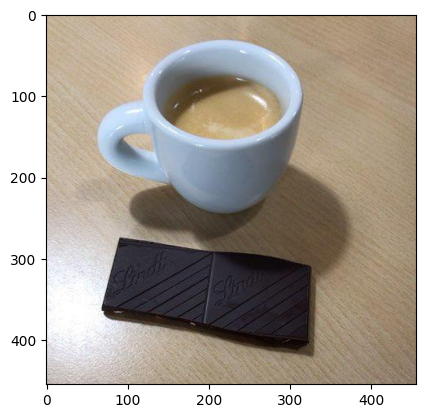

In [40]:
path = '../fdata/val/images/' + '149022.jpg'
get_image = Image.open(path)
plt.imshow(get_image)
plt.show()

In [41]:
get_image.size

(455, 455)

In [42]:
get_image_1 = cv2.imread(path)

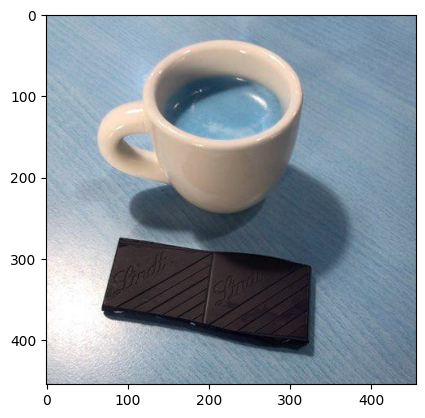

In [43]:
plt.imshow(get_image_1)
plt.show()

In [44]:
A1 = A1.astype(int)

In [45]:
A2 = A2.astype(int)

In [46]:
A1 = tuple(A1)
A1

(65, 65)

In [47]:
A2 = tuple(A2)
A2

(327, 327)

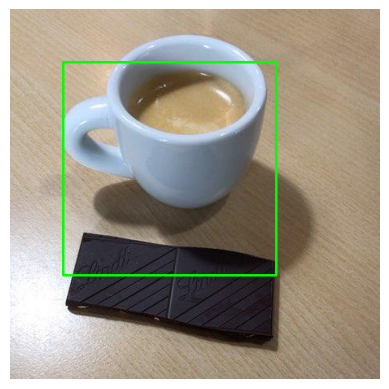

In [48]:
def draw_rectangle(image_path, pt1, pt2, color=(0, 255, 0), thickness=2):
  """
  Draws a rectangle on an image using OpenCV.

  Args:
      image_path (str): Path to the image file.
      pt1 (tuple): Top-left corner coordinates of the rectangle (x, y).
      pt2 (tuple): Bottom-right corner coordinates of the rectangle (x, y).
      color (tuple, optional): Color of the rectangle in BGR format. Defaults to green (0, 255, 0).
      thickness (int, optional): Thickness of the rectangle line. Defaults to 2.

  Returns:
      numpy.ndarray: The image with the drawn rectangle.
  """

  # Read the image
  img = cv2.imread(image_path)

  # Check if image is read successfully
  if img is None:
      print("Error: Could not read image from", image_path)
      return None

  # Draw the rectangle
  cv2.rectangle(img, pt1, pt2, color, thickness)

  return img

# Example usage
# image_path = "your_image.jpg"  # Replace with your image path
# pt1 = (100, 50)  # Top-left corner coordinates
# pt2 = (200, 150)  # Bottom-right corner coordinates

# Draw the rectangle and get the resulting image
result_image = draw_rectangle(path, A1, A2)
# Convert image to RGB format for matplotlib (OpenCV uses BGR)

img_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# Display the image in the notebook
plt.imshow(img_rgb)
# plt.imshow(result_image)
plt.axis('off')  # Optional: Hide axes
plt.show()

In [49]:
A1

(65, 65)

In [50]:
A2

(327, 327)

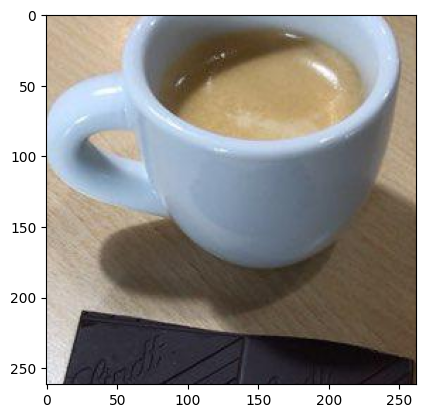

In [51]:
crop_box = (A1[0], A1[1], A2[0], A2[1])
cropped_image = get_image.crop(crop_box)
plt.imshow(cropped_image)
plt.show()

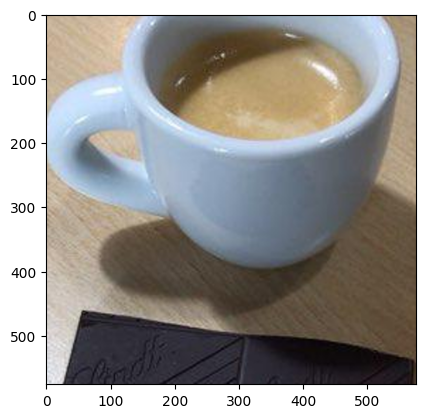

In [52]:
resized_img = cropped_image.resize((576, 576))
plt.imshow(resized_img)
plt.show()

In [53]:
val_save_path = '../new_fdata/val/images/'
original_val_path = '../fdata/val/images/'

In [54]:
len(objData_val['images'])

946

In [55]:
objData_val['images'][0]

{'id': 149022, 'file_name': '149022.jpg', 'width': 455, 'height': 455}

In [56]:
objData_val['images'][0]['file_name']

'149022.jpg'

In [60]:
for element in objData_val['images']:
    key = element['id']
    image_name = element['file_name']
    open_path = original_val_path + image_name
    get_image = Image.open(open_path)
    width, height = get_image.size
    coordinate_matrix = []
    # print(key)
    for i in objData_val['annotations']:
        if i['image_id'] == key:
            coordinate_matrix.append(i['segmentation'][0])
    top_left, bottom_right = crop_seg(coordinate_matrix, width, height)

    crop_box = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

    save_path = val_save_path + image_name

    cropped_image = get_image.crop(crop_box)
    
    cropped_image.save(save_path)

In [64]:
train_save_path = '../new_fdata/train/images/'
original_train_path = '../fdata/train/images/'

In [65]:
for element in objData_train['images']:
    key = element['id']
    image_name = element['file_name']
    open_path = original_train_path + image_name
    get_image = Image.open(open_path)
    width, height = get_image.size
    coordinate_matrix = []
    for i in objData_train['annotations']:
        if i['image_id'] == key:
            coordinate_matrix.append(i['segmentation'][0])
    top_left, bottom_right = crop_seg(coordinate_matrix, width, height)

    crop_box = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

    save_path = train_save_path + image_name

    cropped_image = get_image.crop(crop_box)
    
    cropped_image.save(save_path)